In [ ]:
!nvidia-smi

Wed Apr 21 02:38:18 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    25W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!cat /proc/uptime | awk '{print $1 /60 /60 /24 "days (" $1 "sec)"}'

0.000681019days (58.84sec)


In [ ]:
!git clone https://github.com/yours-schnee/custom_ImageNet.git

Cloning into 'custom_ImageNet'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 57 (delta 19), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
!pip install -e ./custom_ImageNet

ERROR: File "setup.py" not found. Directory cannot be installed in editable mode: /content/custom_ImageNet


In [ ]:
import sys
sys.path.append('/content/custom_ImageNet')

import custom_ImageNet
from utils.ImageNetDataset import make_path_list
from utils.ImageNetDataset import str_convert
from utils.ImageNetDataset import ImageNetDataset

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn import init
from torch.optim import lr_scheduler
from torch import optim

In [ ]:
import glob
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.autonotebook import tqdm

from torchvision import transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.metrics import classification_report
import statistics
import itertools
np.set_printoptions(threshold=np.inf)
#from PIL import Image  
import PIL
import PIL.Image
from PIL import ImageFile

#import copy
from copy import deepcopy
from torchsummary import summary
import torch.utils.data as data
import datetime

!pip install tensorboardX
import tensorboardX as tbx
from tensorboardX import SummaryWriter


     |████████████████████████████████| 122kB 13.2MB/s 


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp "drive/My Drive/ImageNet/retina_10random_ImagenetTrain.zip" /content/
!cp "drive/My Drive/ImageNet/retina_original_ImagenetTest.zip" /content/

In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [ ]:
!7z x retina_10random_ImagenetTrain.zip
!mv "content/retina_ImagenetTrain" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2888291374 bytes (2755 MiB)

Extracting archive: retina_10random_ImagenetTrain.zip
  2% 4096 Open              --
Path = retina_10random_ImagenetTrain.zip
Type = zip
Physical Size = 2888291374
64-bit = +

  0%      0% 554 - content/retina_ImagenetTrain/pineapple/pineapple_6730.jpg                                                                      0% 936 - content/retina_ImagenetTrain/pineapple/pineapple_6255.jpg                                                                    

In [ ]:
!7z x retina_original_ImagenetTest.zip
!mv "content/retina_ImagenetTest" ../content/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 34489251 bytes (33 MiB)

Extracting archive: retina_original_ImagenetTest.zip
--
Path = retina_original_ImagenetTest.zip
Type = zip
Physical Size = 34489251

  0%     25% 516 - content/retina_ImagenetTest/apple/apple_034.jpg                                                           63% 1297          93% 1889 - content/retina_ImagenetTest/broccoli/broccoli_088.jpg                                                                 Everything is Ok

Folde

In [ ]:
import shutil

directory = 'content'

try:
    shutil.rmtree(directory)
except FileNotFoundError:
    pass

In [ ]:
rootpathTrain ='retina_ImagenetTrain/'
rootpathTest ='retina_ImagenetTest/'

# Get folder name
train_img_list = make_path_list(rootpathTrain)
test_img_list = make_path_list(rootpathTest)

In [ ]:
simple_transform = transforms.Compose([transforms.Resize((224,224),interpolation=3),
                                       transforms.ToTensor()])

train_dataset = ImageNetDataset(train_img_list, phase="train", transform=simple_transform)

test_dataset = ImageNetDataset(test_img_list, phase="test",
                          transform=simple_transform)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [ ]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
np.random.seed(6)
device = torch.device("cuda" if use_cuda else "cpu")
#classes_list = train_dataset.get_label_relation()
classes_list = test_dataset.get_label_relation()

batch_size = 32

In [ ]:
# training data split to train and val
validation_split = .2

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

# Creating PT data samplers
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

In [ ]:
# dataloder
trainloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)

valloader = data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=val_sampler, num_workers=2)

#trainloader = data.DataLoader(
#    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

testloader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

dataloaders_dict = {"train": trainloader, "val": valloader}

In [ ]:
index_dict = {"train": train_idx, "val": valid_idx}
len(index_dict["train"])

141568

In [ ]:
"""cnt = 0
for epoch in range(2):
    for images, labels in tqdm(testloader):
        cnt += 1
        if (cnt%10)
        print()"""

'cnt = 0\nfor epoch in range(2):\n    for images, labels in tqdm(testloader):\n        cnt += 1\n        if (cnt%10)\n        print()'

--------------------
(224, 224, 3)


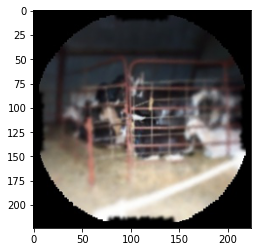

In [ ]:
index = 2
imges, label = test_dataset.__getitem__(index)

img_val = imges
img_val = img_val.numpy().transpose((1, 2, 0))
print("--------------------")
print(img_val.shape)
plt.imshow(img_val)
plt.show()


In [ ]:
#code adapted from https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion(cm, classes, name, normalize=False, title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    #print(cm)
    filename= name + "_confusion.png"
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/"
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:0.0f}".format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(path+filename)


In [ ]:
def plot_graph(training_losses,val_losses,epochs,string,name):
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel(string)

    filename = name + "_" + string + "_.png" 
    path = F"/content/drive/My Drive/Colab Notebooks/Graphs/{filename}"
    plt.title(string + 'per epoch - ' + "Simple classifier")
    
    plt.plot(range(epochs),training_losses,label="Training " + string)
    plt.plot(range(epochs),val_losses,label="Validation " + string)
    plt.legend()
    plt.savefig(path+filename)
    print(path+filename)

In [ ]:
# This function will test mask image generation, not the difference between original and generated images
  
def test_model(model, criterion, name):

    model.eval()
    test_epoch_loss = 0
    test_correct = 0
    best_accuracy = 0
    class_correct = list(0 for i in range(N_CLASSES))
    class_total = list(0 for i in range(N_CLASSES))
    mean_accuracies = list(0 for i in range(n_iterations))
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        accuracies = [[] for i in range(n_iterations)]
        #for index,(images, anno, labels) in enumerate(testloader):
        for index,(images, labels) in enumerate(testloader):
            images, labels = images.cuda(), labels.cuda()

            predicted = model(images)
            loss = criterion(predicted,labels)

            test_epoch_loss += loss.item()

            best_predicted = predicted
            _, predicted_l = torch.max(best_predicted.data, 1)
            test_correct += (predicted_l == labels).sum().item()
            c = (predicted_l == labels).squeeze()

            predlist=torch.cat([predlist,predicted_l.view(-1).cpu()])
            labelslist=torch.cat([labelslist,labels.view(-1).cpu()])

            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    test_epoch_loss /= len(testloader)
    print('\nTest loss: {:.4f} \nTesting Accuracy: {}/{} ({:.2f}%)'.format(
          test_epoch_loss, test_correct, len(testloader.dataset),
          100. * test_correct / len(testloader.dataset)))
    for i in range(N_CLASSES):
        print("{} Class Accuracy: {}/{} ({:.2f}%)".format(classes_list[i],class_correct[i],class_total[i],100*class_correct[i]/class_total[i]))

    precision = precision_score(predlist.numpy(), labelslist.numpy(), average='macro')
    recall = recall_score(predlist.numpy(), labelslist.numpy(), average='macro')
    accuracy = accuracy_score(predlist.numpy(), labelslist.numpy())
    f1 = fbeta_score(predlist.numpy(), labelslist.numpy(), 1, average='macro') #1 means f_1 measure
    print("Classifier has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (accuracy,precision,recall,f1))
    conf_matrix=confusion_matrix(labelslist.numpy(), predlist.numpy())
    plt.figure(figsize=(8, 8))
    plot_confusion(conf_matrix, classes_list, name, 'Confusion matrix')
    print(classification_report(labelslist.numpy(), predlist.numpy(),target_names=classes_list))

    return mean_accuracies

### Loss function

In [ ]:
# Loss fuc setting
criterion = nn.CrossEntropyLoss()

### Training & Test for model

In [ ]:
def train_model(model, dataloaders_dict, criterion, optimizer, num_epochs, name, folder_name, debug_mode=False):
    
    log_path = F"/content/drive/My Drive/Colab Notebooks/Log/"
    now = datetime.datetime.now()
    folder = F"{name}"+now.strftime('%Y%m%d_%H%M%S')

    writer = tbx.SummaryWriter(log_path+folder)

    global best_accuracy;
    global training_losses; global val_losses;
    global train_accuracies; global val_accuracies;
    global epochs;
    global stats;
    train_loss=0; val_loss=0; train_acc=0; val_acc=0; 
    for epoch in range(epochs,num_epochs):
        epoch = epoch + 1
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-------------')

        # loop for training and validation every epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # training mode
            else:
                model.eval()    # validation mode

            epoch_loss = 0.0    # epoch loss
            epoch_acc = 0       # epoch correct

            #for images, anno, labels in tqdm(dataloaders_dict[phase]):
            for images, labels in tqdm(dataloaders_dict[phase]):
                #images, anno, labels = images.cuda(), anno.cuda(), labels.cuda()
                images, labels = images.cuda(), labels.cuda()
      
                # initialize optimizer
                optimizer.zero_grad()

                # feedforward calc
                with torch.set_grad_enabled(phase == 'train'):
                    predicted = model(images)
                    loss = criterion(predicted, labels)       # loss calc
                    preds = predicted.max(1,keepdim=True)[1]  # label preds

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # calc of iter results
                    epoch_loss += loss.item()
                    epoch_acc += preds.eq(labels.view_as(preds)).sum().item()

            #print(epoch_acc)
            epoch_loss = epoch_loss / len(index_dict[phase])
            epoch_acc = epoch_acc / len(index_dict[phase]) *100.
            
            # stats data save
            if phase == 'train':
                training_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
                train_loss=epoch_loss; train_acc=epoch_acc;
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc)
                val_loss=epoch_loss; val_acc=epoch_acc;

                # best model save
                if (epoch_acc > best_accuracy) and debug_mode==False:
                    best_accuracy = epoch_acc
                    best_model = deepcopy(model)
                    
                    total_name = name+".tar"
                    path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
                    torch.save({"best_model":model.state_dict(),
                                "best_acc":best_accuracy
                                },path)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if epoch%2==0:
            # Colab's disconnection timing while saving data might cause the broken save data against our hope.
            # So, results every epochs will be saved every epochs.
            
            total_name = name+"_epoch"+str(epoch)+".tar"

            path = F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"
            torch.save({
                "epoch":epoch,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_loss":training_losses,
                "val_loss":val_losses,
                "train_acc":train_accuracies,
                "val_acc":val_accuracies
                }, path)
            
        print('-------------')
        writer.add_scalars('/loss', {'train_loss': train_loss,
                                     'val_loss': val_loss
                                    }, epoch)
      
        writer.add_scalars('/acc', {'train_acc': train_acc,
                                    'val_acc': val_acc
                                    }, epoch)

    print("Lowest training loss", min(training_losses))
    print("Lowest validation loss", min(val_losses))
    print("Highest training accuracy",max(train_accuracies))
    print("Highest validation accuracy",max(val_accuracies))
    print('-------------')

    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

    return best_model, stats

### VGG16 fine tuning

In [ ]:
# Load pre-trained VGG-16
use_pretrained = False
net = models.vgg16(pretrained=use_pretrained)

N_CLASSES = 20

# Replacement last layer output for 20 classes
net.classifier[6] = nn.Linear(in_features=4096, out_features=N_CLASSES)

net.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
"""# Store parameters through transfer learning, which are re-trained
params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# Re-trained params
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# Non re-trained params keep their grads
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1 stores：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2 stores：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3 stores：", name)

    else:
        param.requires_grad = False
        print("Freazed：", name)"""

'# Store parameters through transfer learning, which are re-trained\nparams_to_update_1 = []\nparams_to_update_2 = []\nparams_to_update_3 = []\n\n# Re-trained params\nupdate_param_names_1 = ["features"]\nupdate_param_names_2 = ["classifier.0.weight",\n                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]\nupdate_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]\n\n# Non re-trained params keep their grads\nfor name, param in net.named_parameters():\n    if update_param_names_1[0] in name:\n        param.requires_grad = True\n        params_to_update_1.append(param)\n        print("params_to_update_1 stores：", name)\n\n    elif name in update_param_names_2:\n        param.requires_grad = True\n        params_to_update_2.append(param)\n        print("params_to_update_2 stores：", name)\n\n    elif name in update_param_names_3:\n        param.requires_grad = True\n        params_to_update_3.append(param)\n        print("params_to_update_3 stores

In [ ]:
"""vgg_optimizer2 = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
], momentum=0.9)"""

"vgg_optimizer2 = optim.SGD([\n    {'params': params_to_update_1, 'lr': 1e-4},\n    {'params': params_to_update_2, 'lr': 5e-4},\n    {'params': params_to_update_3, 'lr': 1e-3}\n], momentum=0.9)"

In [ ]:
# Optimization setting
vgg_optimizer2 = optim.SGD(net.parameters(), lr=0.007, momentum=0.9)

### CONST data

In [ ]:
# for FC layer's input size computation
img_shapes = [224, 224]

DEBUG = False
if DEBUG:
    NUM_EPOCS = 14
else:
    NUM_EPOCS = 40

n_iterations = 50
N_CLASSES = 20
FC_H = img_shapes[0]//2**4 # 4 is max plling layer num
FC_W = img_shapes[1]//2**4

In [ ]:
LOAD_STATE = True
EPOCH = 28             # This values need to check the latest tar ffile name with epoch.
name = "05_VGG_fine"
folder_name = "VGG_fine"

if LOAD_STATE:
    stats=[];
    
    PATH1 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{name}.tar"

    checkpoint = torch.load(PATH1)
    best_model = net
    best_model.load_state_dict( checkpoint["best_model"] )
    best_accuracy = 0#checkpoint["best_acc"]

    # Colab's disconnection timing while saving data might cause the broken save data against our hope.
    # So, results every epochs will be saved every epochs.
    total_name = name+"_epoch"+str(EPOCH)+".tar"
    PATH2 =  F"/content/drive/My Drive/Colab Notebooks/Retina_image/{folder_name}/{total_name}"

    checkpoint = torch.load(PATH2)
    epochs = checkpoint["epoch"]
    net.load_state_dict( checkpoint["model_state_dict"] )
    vgg_optimizer2.load_state_dict( checkpoint["optimizer_state_dict"] )
    training_losses = checkpoint["train_loss"]; val_losses = checkpoint["val_loss"];
    train_accuracies = checkpoint["train_acc"]; val_accuracies = checkpoint["val_acc"];
    stats.append(training_losses)
    stats.append(train_accuracies)
    stats.append(val_losses)
    stats.append(val_accuracies)

else:
    # start point
    best_model=net;
    best_accuracy = 0;
    training_losses = []; val_losses = [];
    train_accuracies = []; val_accuracies = [];
    stats=[];
    epochs=0;


In [ ]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

In [ ]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 29/40
-------------



train Loss: nan Acc: 4.8471


val Loss: nan Acc: 4.9390
-------------
Epoch 30/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390


-------------
Epoch 31/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390
-------------
Epoch 32/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390


-------------
Epoch 33/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390
-------------
Epoch 34/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390


-------------
Epoch 35/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390
-------------
Epoch 36/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390


-------------
Epoch 37/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390
-------------
Epoch 38/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390


-------------
Epoch 39/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390
-------------
Epoch 40/40
-------------



train Loss: nan Acc: 4.8471



val Loss: nan Acc: 4.9390


-------------
Lowest training loss 0.01885674863715427
Lowest validation loss 0.032060633045511745
Highest training accuracy 80.36703209764919
Highest validation accuracy 68.46462477396021
-------------


In [ ]:
best_vgg2, stats_vgg2 = train_model(net, dataloaders_dict, criterion, vgg_optimizer2, NUM_EPOCS, name, folder_name, DEBUG)

Epoch 1/40
-------------



train Loss: 0.0781 Acc: 19.5284



val Loss: 0.0708 Acc: 27.1785
-------------
Epoch 2/40
-------------



train Loss: 0.0672 Acc: 30.5479



val Loss: 0.0608 Acc: 37.8899
-------------
Epoch 3/40
-------------



train Loss: 0.0578 Acc: 40.9556



val Loss: 0.0518 Acc: 46.1121
-------------
Epoch 4/40
-------------



train Loss: 0.0502 Acc: 48.6296



val Loss: 0.0468 Acc: 51.3506
-------------
Epoch 5/40
-------------



train Loss: 0.0438 Acc: 54.8966



val Loss: 0.0437 Acc: 55.0209
-------------
Epoch 6/40
-------------



train Loss: 0.0383 Acc: 60.4642



val Loss: 0.0405 Acc: 58.2307
-------------
Epoch 7/40
-------------



train Loss: 0.0336 Acc: 65.1037



val Loss: 0.0360 Acc: 62.9097
-------------
Epoch 8/40
-------------



train Loss: 0.0297 Acc: 68.9824



val Loss: 0.0345 Acc: 65.1079
-------------
Epoch 9/40
-------------



train Loss: 0.0262 Acc: 72.5404



val Loss: 0.0338 Acc: 66.6083
-------------
Epoch 10/40
-------------



train Loss: 0.0237 Acc: 75.3454



val Loss: 0.0332 Acc: 67.0575
-------------
Epoch 11/40
-------------



train Loss: 0.0216 Acc: 77.4871



val Loss: 0.0336 Acc: 66.8032
-------------
Epoch 12/40
-------------



train Loss: 0.0203 Acc: 78.7071



val Loss: 0.0321 Acc: 68.4646
-------------
Epoch 13/40
-------------



train Loss: 0.0194 Acc: 79.7906



val Loss: 0.0361 Acc: 64.9158
-------------
Epoch 14/40
-------------



train Loss: 0.0189 Acc: 80.3670



val Loss: 0.0344 Acc: 65.9217
-------------
Epoch 15/40
-------------



train Loss: 0.0190 Acc: 80.3430



val Loss: 0.0346 Acc: 65.9951
-------------
Epoch 16/40
-------------



train Loss: 0.0194 Acc: 80.0223



val Loss: 0.0350 Acc: 65.8623
-------------
Epoch 17/40
-------------



train Loss: 0.0198 Acc: 79.5724



val Loss: 0.0370 Acc: 63.6132
-------------
Epoch 18/40
-------------



train Loss: 0.0213 Acc: 78.1575



val Loss: 0.0377 Acc: 63.3929
-------------
Epoch 19/40
-------------



train Loss: 0.0235 Acc: 75.9437



val Loss: 0.0414 Acc: 59.2733
-------------
Epoch 20/40
-------------



train Loss: 0.0263 Acc: 73.2955



val Loss: 0.0437 Acc: 57.8492
-------------
Epoch 21/40
-------------



train Loss: 0.0323 Acc: 67.2899



val Loss: 0.0476 Acc: 55.1678
-------------
Epoch 22/40
-------------



train Loss: 0.0429 Acc: 57.0630



val Loss: 0.0588 Acc: 43.7443
-------------
Epoch 23/40
-------------



train Loss: 0.0568 Acc: 43.4392



val Loss: 0.0690 Acc: 32.6401
-------------
Epoch 24/40
-------------



train Loss: nan Acc: 17.6481



val Loss: nan Acc: 4.9164


-------------
Epoch 25/40
-------------



train Loss: nan Acc: 4.8528



val Loss: nan Acc: 4.9164
-------------
Epoch 26/40
-------------


/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_Loss _.png05_VGG_fine_Loss _.png
/content/drive/My Drive/Colab Notebooks/Graphs/05_VGG_fine_Accuracy _.png05_VGG_fine_Accuracy _.png


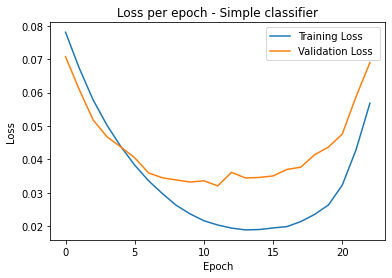

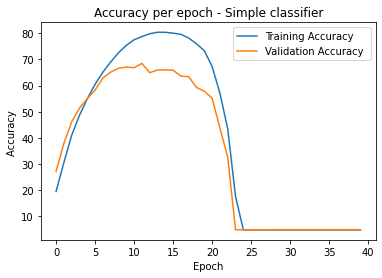

In [ ]:
plt.rcParams["figure.figsize"] = (6,4)
plot_graph(stats_vgg2[0],stats_vgg2[2],NUM_EPOCS,"Loss ",name)
plot_graph(stats_vgg2[1],stats_vgg2[3],NUM_EPOCS,"Accuracy ",name)


Test loss: nan 
Testing Accuracy: 100/2000 (5.00%)
apple Class Accuracy: 100/100 (100.00%)
banana Class Accuracy: 0/100 (0.00%)
bear Class Accuracy: 0/100 (0.00%)
bell_pepper Class Accuracy: 0/100 (0.00%)
bird Class Accuracy: 0/100 (0.00%)
broccoli Class Accuracy: 0/100 (0.00%)
cat Class Accuracy: 0/100 (0.00%)
cauliflower Class Accuracy: 0/100 (0.00%)
cow Class Accuracy: 0/100 (0.00%)
dog Class Accuracy: 0/100 (0.00%)
elephant Class Accuracy: 0/100 (0.00%)
fox Class Accuracy: 0/100 (0.00%)
goat Class Accuracy: 0/100 (0.00%)
horse Class Accuracy: 0/100 (0.00%)
mashed_potato Class Accuracy: 0/100 (0.00%)
orange Class Accuracy: 0/100 (0.00%)
pineapple Class Accuracy: 0/100 (0.00%)
pomegranate Class Accuracy: 0/100 (0.00%)
tomato Class Accuracy: 0/100 (0.00%)
zebra Class Accuracy: 0/100 (0.00%)
Classifier has Acc=0.050 P=0.050 R=0.003 F1=0.005


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        apple       0.05      1.00      0.10       100
       banana       0.00      0.00      0.00       100
         bear       0.00      0.00      0.00       100
  bell_pepper       0.00      0.00      0.00       100
         bird       0.00      0.00      0.00       100
     broccoli       0.00      0.00      0.00       100
          cat       0.00      0.00      0.00       100
  cauliflower       0.00      0.00      0.00       100
          cow       0.00      0.00      0.00       100
          dog       0.00      0.00      0.00       100
     elephant       0.00      0.00      0.00       100
          fox       0.00      0.00      0.00       100
         goat       0.00      0.00      0.00       100
        horse       0.00      0.00      0.00       100
mashed_potato       0.00      0.00      0.00       100
       orange       0.00      0.00      0.00       100
    pineapple       0.00      0.00      0.00       100
  pomegra

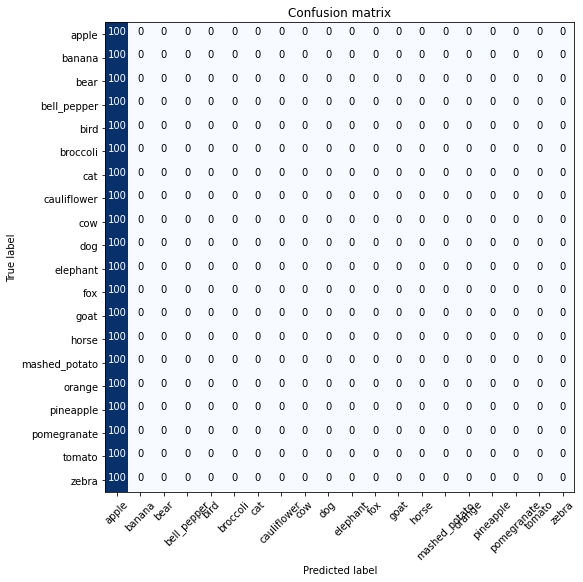

In [ ]:
result = test_model(best_vgg2,criterion, name)